# NASA Exoplanet Archive Exploratory Data Analysis

Dataset source: https://exoplanetarchive.ipac.caltech.edu/docs/counts_detail.html

Dataset type: Planetary Systems Composite Parameters <a href="#footnote-1">[1]</a>

Dataset exported on **2023-04-01**

The NASA Exoplanet Archive is an astronomical exoplanet and stellar catalog that collates and cross-correlates astronomical data and information on exoplanets and their host stars. These data include stellar parameters (such as positions, magnitudes, and temperatures), exoplanet parameters (such as masses and orbital parameters) and discovery/characterization data (such as published radial velocity curves, photometric light curves, images, and spectra).

Data column definition can be found on the [README.md](README.md) file.

<p id="footnote-1">[1] The parameters in a given row may have been drawn from different sources and may have calculated values that are not necessarily self-consistent.</p>

## What is an exoplanet?

An exoplanet is a planet located outside of our solar system. While most orbit around other stars, some exoplanets freely float around the galaxy instead, known as rogue planets. For every star you see in the night sky, on average, has at least one planet. Majority of exoplanets found to date are located in the Milky Way which is only a small sample of the galaxy. In a decade, the number of exoplanets discovered could potentially increase to tens of thousands as more robotic telescopes are launched into space with better observing capabilities.

## Goal

In this project, our goal is to explore the exoplanet dataset and prepare it for machine learning training. Although we haven't determined specific machine learning goals yet, we will gain a better understanding of what's possible as we explore the data.

## Load and preprocess dataset

The dataset has been exported as a CSV file. Most of the planetary parameters come with positive/negative uncertainties and limit flag columns. For the initial exploration, we can simplify the data by ignoring these variables. Later on, when we determine which measurements are crucial to our analysis, we can review the uncertainty values to obtain a more accurate representation.

Some data in the dataset are stored as 0 or 1 in int64 format, but they can be more appropriately represented as boolean values. The documentation defines them as binary data, and converting them to bool can make the dataset more efficient and easier to work with.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('exoplanet_dataset.csv')

# Drop the uncertainties and limit columns to simplify the data
df = df.drop([col_name for col_name in df if col_name.endswith(('err1', 'err2', 'lim'))], axis=1)

# Update the data type int64 into bool on boolean columns as documented in the column definition
bool_col_names = ['rv_flag', 'pul_flag', 'ptv_flag', 'tran_flag', 'ast_flag', 'obm_flag', 'micro_flag', 'etv_flag', 'ima_flag', 'dkin_flag', 'ttv_flag', 'cb_flag']
df[bool_col_names] = df[bool_col_names].astype(bool)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5322 entries, 0 to 5321
Data columns (total 90 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   pl_name          5322 non-null   object 
 1   hostname         5322 non-null   object 
 2   sy_snum          5322 non-null   int64  
 3   sy_pnum          5322 non-null   int64  
 4   sy_mnum          5322 non-null   int64  
 5   cb_flag          5322 non-null   bool   
 6   discoverymethod  5322 non-null   object 
 7   disc_year        5322 non-null   int64  
 8   disc_locale      5322 non-null   object 
 9   disc_facility    5322 non-null   object 
 10  disc_telescope   5322 non-null   object 
 11  disc_instrument  5322 non-null   object 
 12  rv_flag          5322 non-null   bool   
 13  pul_flag         5322 non-null   bool   
 14  ptv_flag         5322 non-null   bool   
 15  tran_flag        5322 non-null   bool   
 16  ast_flag         5322 non-null   bool   
 17  obm_flag      

## Detect missing values

Identify columns with a high number of missing values and consider dropping those that are not significant or difficult to impute.

In [2]:
percent_missing = df.isnull().sum() * 100 / len(df)
print(f"Number of columns with >= 30% of data missing: {len(percent_missing.loc[lambda p : p > 30])}")
percent_missing.loc[lambda p : p > 30].sort_values(ascending=False)

Number of columns with >= 30% of data missing: 18


pl_trueobliq    99.492672
pl_occdep       99.417512
pl_projobliq    97.200301
sy_icmag        93.987223
st_rotp         89.440060
sy_umag         88.124765
pl_orbtper      82.468997
pl_orblper      71.119880
st_vsin         65.163472
st_spectype     64.468245
pl_rvamp        64.261556
st_radv         59.037956
sy_zmag         42.502818
sy_imag         38.519354
sy_gmag         37.842916
sy_rmag         37.523487
sy_kepmag       36.715520
pl_insol        30.890643
dtype: float64

## Imputation

Stellar spectral type (*st_spectype*) can be imputed using stellar effective temperature (*st_teff*), stellar luminosity (*st_lum*), stellar radius (*st_rad*) and stellar mass (*st_mass*). The current system follows the Harvard spectral classification in combination with Morgan-Keenan classification. In the MK system, a luminosity class is added to the spectral class using Roman numerals. This is based on the width of certain absorption lines in the star's spectrum, which vary with the density of the atmosphere and so distinguish giant stars from dwarfs. However, the original dataset does not include this information, and therefore the luminosity class cannot be determined. However, we can still utilize the Harvard spectral classification for this column. It should be noted that this classification can be challenging, as some properties of a star may fall under one class while others match a different class. To keep our data consistent, we will override the *st_spectype* with our single letter classification based on the effective temperature even if the value already existed. If effective temperature is not provided, we will fall back to luminosity, then mass. Luckily all data have at least one of these values. Note that the *st_lum* is measured in base 10 logarithmic scale. 

<div align="center">Harvard Spectral Classification </div>

| Class | Effective temperature (K) | Solar mass (M☉) | Solar radii (R☉) | Luminosity (L☉) |
|-------|---------------------------|-----------------|------------------|-----------------|
| O     | ≥ 30,000                  | ≥ 16            | ≥ 6.6            | ≥ 30,000        |
| B     | 10,000–30,000             | 2.1–16          | 1.8–6.6          | 25–30,000       |
| A     | 7,500–10,000              | 1.4–2.1         | 1.4–1.8          | 5–25            |
| F     | 6,000–7,500               | 1.04–1.4        | 1.15–1.4         | 1.5–5           |
| G     | 5,200–6,000               | 0.8–1.04        | 0.96–1.15        | 0.6–1.5         |
| K     | 3,700–5,200               | 0.45–0.8        | 0.7–0.96         | 0.08–0.6        |
| M     | 2,400–3,700               | 0.08–0.45       | ≤ 0.7            | ≤ 0.08          |



In [3]:
import math        
        
def spectral_class(temp, lum, mass):
    temp_bounds = [(30000, 'O'), (10000, 'B'), (7500, 'A'), (6000, 'F'), (5200, 'G'), (3700, 'K'), (0, 'M')]
    lum_bounds = [(30000, 'O'), (25, 'B'), (5, 'A'), (1.5, 'F'), (0.6, 'G'), (0.08, 'K'), (0, 'M')]
    mass_bounds = [(16, 'O'), (2.1, 'B'), (1.4, 'A'), (1.04, 'F'), (0.8, 'G'), (0.45, 'K'), (0, 'M')]
    
    if not math.isnan(temp):
        for bound, spectral_class in temp_bounds:
            if temp >= bound:
                return spectral_class
    elif not math.isnan(lum):
        for bound, spectral_class in lum_bounds:
            if lum >= bound:
                return spectral_class
    elif not math.isnan(mass):
        for bound, spectral_class in mass_bounds:
            if mass >= bound:
                return spectral_class
    return None

df['st_spectype'] = df.apply(lambda row: spectral_class(row['st_teff'],
                                                        np.power(10, row['st_lum']),
                                                        row['st_mass']), axis=1)
df[['pl_name', 'st_spectype', 'st_teff', 'st_lum', 'st_mass']].sort_values(by='st_spectype', ascending=False)

,pl_name,st_spectype,st_teff,st_lum,st_mass
4653,NN Ser d,O,57000.00,NaN,0.54
4656,NY Vir c,O,32780.00,1.375,0.46
4655,NY Vir b,O,32780.00,1.375,0.46
4654,NSVS 14256825 b,O,40000.00,1.974,0.42
4652,NN Ser c,O,57000.00,NaN,0.54
...,...,...,...,...,...
5282,bet Pic b,A,8038.68,0.953,1.80
5283,bet Pic c,A,7890.00,0.958,1.80
4761,PSR B1257+12 d,A,NaN,NaN,1.40
1058,HD 56414 b,A,8500.00,1.158,1.89


## Drop features with high number of null values

Remove the rest of columns with high number of null values that can't be imputed.

In [4]:
col_to_remove = list((df.isnull().sum() / len(df)).loc[lambda p : p > 0.3].sort_values(ascending=False).index) # Drop columns with missing data >= 30%
print(f"Removing columns: {col_to_remove}")
df = df.drop(col_to_remove, axis=1)
print(f"Updated number of columns: {len(df.columns)}")

Removing columns: ['pl_trueobliq', 'pl_occdep', 'pl_projobliq', 'sy_icmag', 'st_rotp', 'sy_umag', 'pl_orbtper', 'pl_orblper', 'st_vsin', 'pl_rvamp', 'st_radv', 'sy_zmag', 'sy_imag', 'sy_gmag', 'sy_rmag', 'sy_kepmag', 'pl_insol']
Updated number of columns: 73


## Drop highly correlated features

It's worth noting that some columns in the dataset may contain redundant information and should be removed as features when developing regression models to avoid potential issues like multicollinearity. For example, multiple columns may represent the same data in different measuring units. In addition to these obvious cases, there may be other less apparent ones that we can detect using Pandas pairwise correlation function and visualize the correlation strength in a heatmap..

When selecting a correlation method, Pandas provide us with three options: Pearson, Spearman, or Kendall. The **Pearson** method is most suitable for interval or ratio data that is linear, normally distributed, and has no outliers. **Spearman** method is similar to Pearson's, but does not require data normalization and is less sensitive to outliers. The **Kendall** method like Spearman, can be used on non-parametric data, and is also suitable for analyzing ordinal or continuous data.

Given that the current dataset has not been normalized or cleaned of outliers, it is recommended to use the Spearman or Kendall method to analyze the numerical columns.

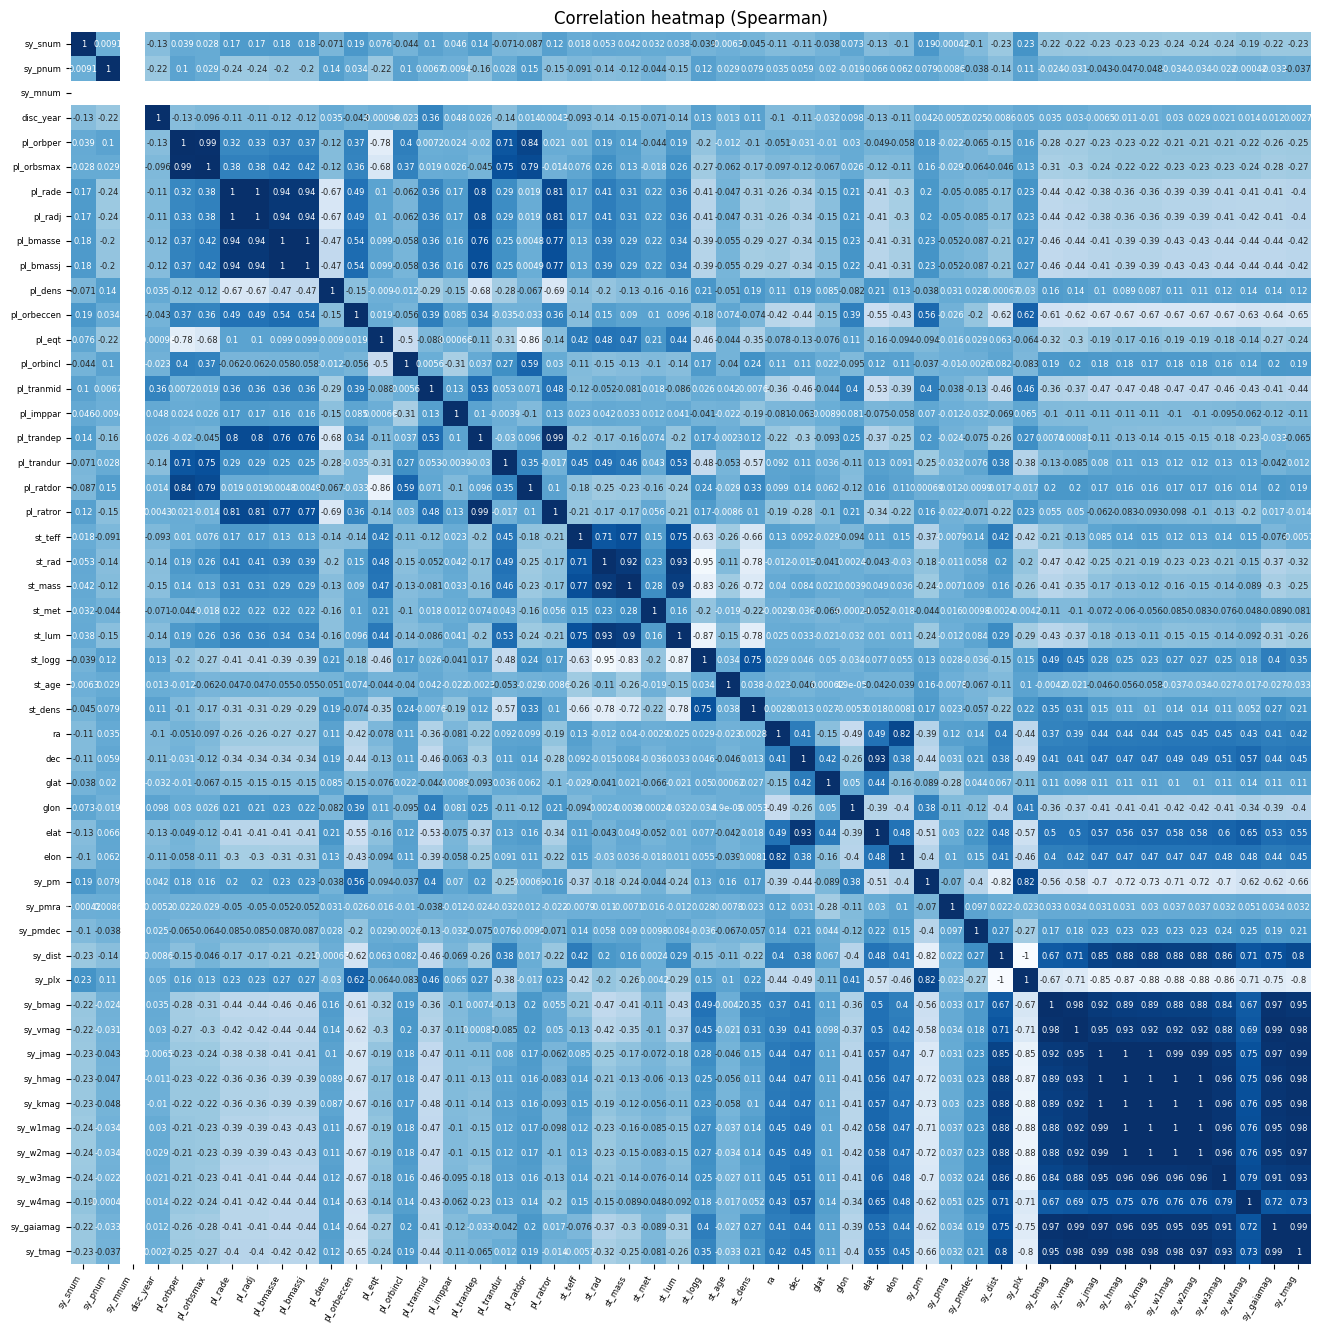

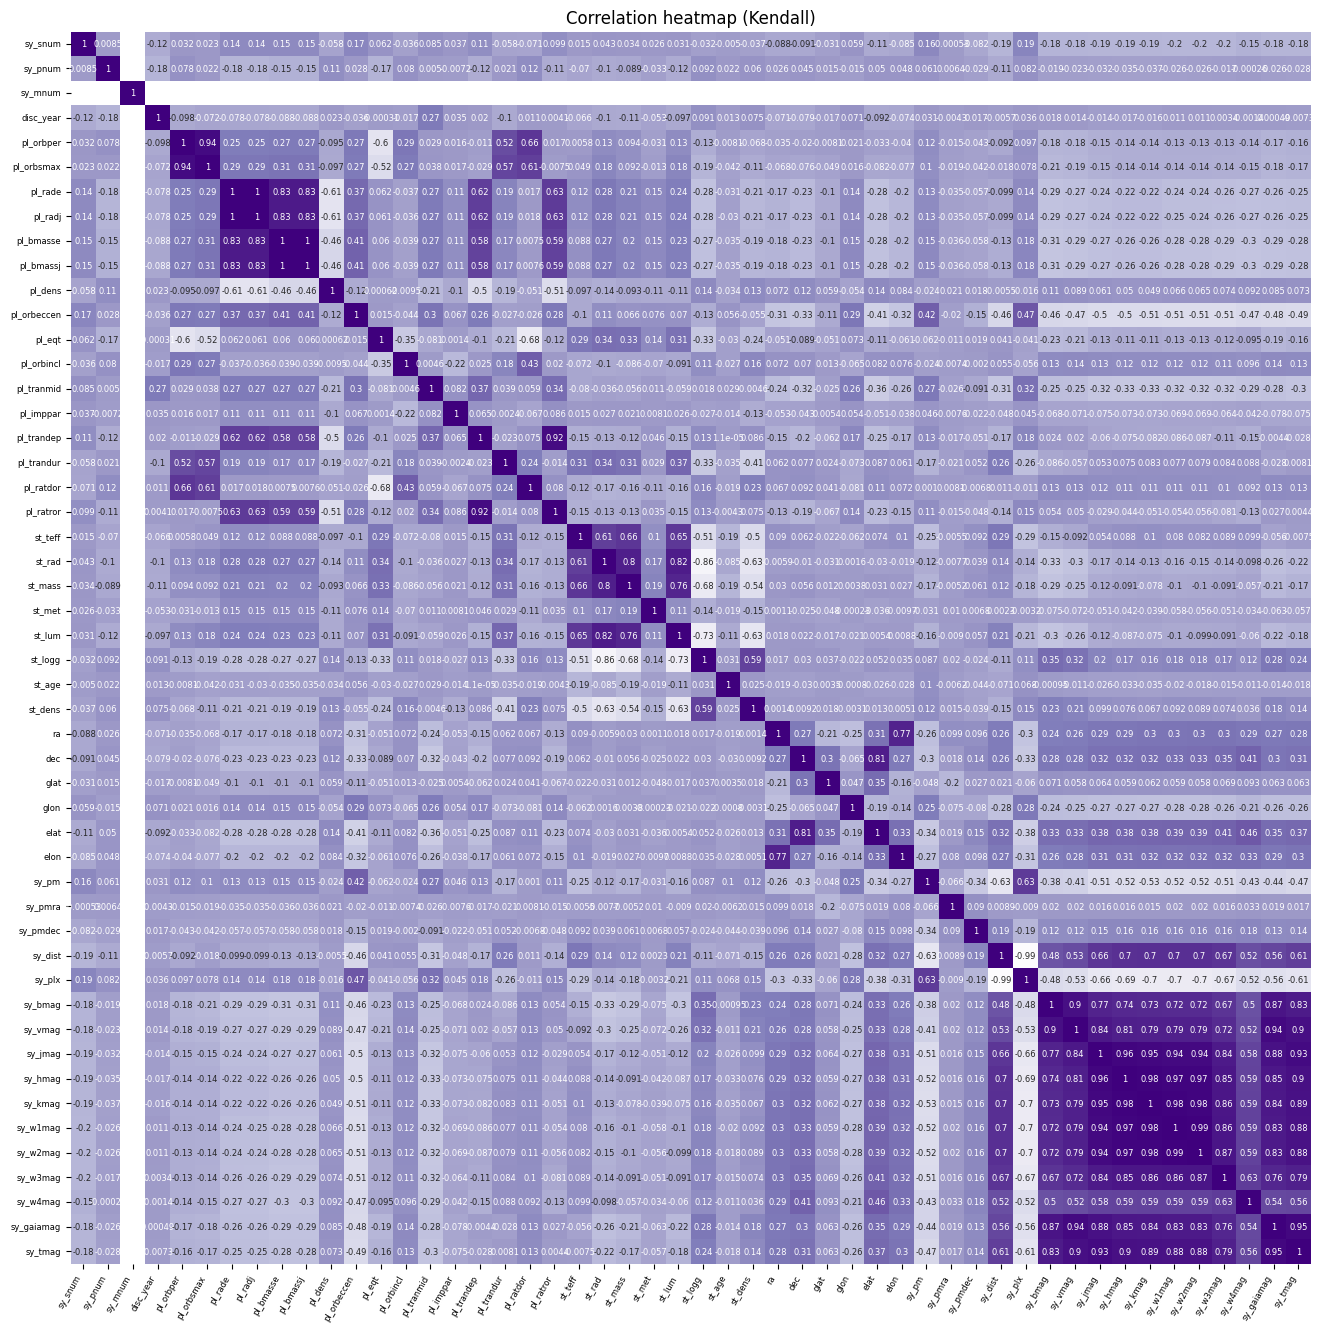

In [5]:
col = df.select_dtypes(include='number')
col_names = list(col.columns)

# Correlation analysis using Spearman
cor_sp = col.corr('spearman')
fig, ax1 = plt.subplots(figsize=(16, 16))
sns.heatmap(cor_sp, cmap='Blues', annot=True, ax=ax1, annot_kws={'fontsize':6}, cbar=False)
ax1.set_xticklabels(col_names, rotation=60, ha='right', fontsize=6)
ax1.set_yticklabels(col_names, rotation=0, ha='right', fontsize=6)
ax1.set_title('Correlation heatmap (Spearman)')

# Correlation analysis using Kendall
cor_ken = col.corr('kendall')
fig, ax2 = plt.subplots(figsize=(16, 16))
sns.heatmap(cor_ken, cmap='Purples', annot=True, ax=ax2, annot_kws={'fontsize':6}, cbar=False)
ax2.set_xticklabels(col_names, rotation=60, ha='right', fontsize=6)
ax2.set_yticklabels(col_names, rotation=0, ha='right', fontsize=6)
ax2.set_title('Correlation heatmap (Kendall)')

plt.show()

In [6]:
print(f"Unused columns for correlation analysis: \n {set(df.columns) - set(col.columns)}")
print("\n")
print(f"Total number of columns used for correlation analysis: {len(col_names)}")
print("\n")
print("Spearman Analysis")
print("------------------")
print(f"100% correlation: \n {[(col1, col2) for col1 in cor_sp.columns for col2 in cor_sp.columns if col1 < col2 and round(cor_sp.loc[col1, col2]*100,0) == 100]}")
print("\n")
print(f"90% correlation: \n {[(col1, col2) for col1 in cor_sp.columns for col2 in cor_sp.columns if col1 < col2 and round(cor_sp.loc[col1, col2]*100,0) >= 90]}")
print("\n\n")
print("Kendall Analysis")
print("------------------")
print(f"100% correlation: \n {[(col1, col2) for col1 in cor_ken.columns for col2 in cor_ken.columns if col1 < col2 and round(cor_ken.loc[col1, col2]*100,0) == 100]}")
print("\n")
print(f"90% correlation: \n {[(col1, col2) for col1 in cor_ken.columns for col2 in cor_ken.columns if col1 < col2 and round(cor_ken.loc[col1, col2]*100,0) >= 90]}")

Unused columns for correlation analysis: 
 {'cb_flag', 'ast_flag', 'st_spectype', 'st_metratio', 'obm_flag', 'etv_flag', 'rv_flag', 'disc_facility', 'pl_bmassprov', 'pul_flag', 'ra_reflink', 'dkin_flag', 'disc_telescope', 'ptv_flag', 'disc_locale', 'hostname', 'micro_flag', 'ttv_flag', 'tran_flag', 'disc_instrument', 'pl_name', 'ima_flag', 'discoverymethod'}


Total number of columns used for correlation analysis: 50


Spearman Analysis
------------------
100% correlation: 
 [('pl_rade', 'pl_radj'), ('pl_bmasse', 'pl_bmassj'), ('sy_jmag', 'sy_kmag'), ('sy_hmag', 'sy_jmag'), ('sy_hmag', 'sy_kmag'), ('sy_hmag', 'sy_w1mag'), ('sy_hmag', 'sy_w2mag'), ('sy_kmag', 'sy_w1mag'), ('sy_kmag', 'sy_w2mag'), ('sy_w1mag', 'sy_w2mag')]


90% correlation: 
 [('pl_orbper', 'pl_orbsmax'), ('pl_rade', 'pl_radj'), ('pl_bmasse', 'pl_rade'), ('pl_bmasse', 'pl_radj'), ('pl_bmasse', 'pl_bmassj'), ('pl_bmassj', 'pl_rade'), ('pl_bmassj', 'pl_radj'), ('pl_ratror', 'pl_trandep'), ('st_mass', 'st_rad'), ('st_lum',

#### Deciding which columns to drop between the highly correlated columns

The dataset offers two units of measurement for estimating planetary mass: Earth mass and Jupiter mass. Jupiter is roughly 318 times more massive than Earth. Radius measurements can also be given in Jupiter units, with Jupiter having a value of 11.2 Earth radii. Since most exoplanets are much larger than Earth and closer in size to Jupiter, using Jupiter units makes it easier to compare and categorize exoplanets based on their size and characteristics. Therefore, we can drop both *pl_rade* and *pl_bmasse*. 

Furthermore, there is a high correlation among photometry measurements, which are electromagnetic radiation measurements emitted by the host star at different wavelengths. As I am not yet knowledgeable enough to determine which of these measurements is the best representation of the data, and because we do not have a specific analysis goal for our dataset at this point, I will leave them in during the preliminary data cleanup.

#### Correlation between more than two variables
While correlation functions are useful for identifying relationships between pairs of features, they have limitations when it comes to analyzing the relationships among more than two features. For example, I suspect that there must be some correlation between the planetary density *pl_dens* and the *pl_radj* and *pl_bmassj* becasue we can calculate the density using  mass and radius: $Density = {Mass \over Volume}$ and $Volume = {4 \over 3} \cdot \pi \cdot r^3$. But assuming that all planets are perfectly spherical might lead to oversimplified and inaccurate models. Unfortunately, calculating correlations for three or more features at a time is not straightforward, so for now, it may be better to include all features.

In [7]:
df = df.drop(['pl_rade', 'pl_bmasse'], axis=1)

## How do we find exoplanets?

As of the data export date, there are currently **5322** confirmed exoplanets from 3989 different planetary systems!

<div align="center" style="padding: 10px 0 30px 0;">
    <fig>
        <img alt="Kepler Space Telescope spacecraft" src="./img/kepler-spacecraft-model.png" width="300">
        <figcaption align="center">Largest batch of discoveries happened through Kepler space telescope in 2016</figcaption>
    </fig>
</div>


The dataset provides us with the following types of discovery method:

#### Transit
- Searching for shadows
- When planet passes directly between its star and an observer, it dims the star's light by a measureable amount
- 3982 planets discovered (74.8%)
#### Radial Velocity
- Watching for wobble
- Orbiting planets cause stars to wobble in space, changing the color of the light astronomers observe
- 1032 planets discovered (19.4%)
#### Gravitational Microlensing
- Light in a gravity lens
- Light from distant star is bent and focused by gravity as a planet passes between the star and Earth
- 181 planets discovered (3.4%)
#### Direct Imaging
- Taking pictures
- Astronomers can take pictures of exoplanets by removing the overwhelming glare of the stars they orbit
- 64 planets discovered (1.2%)
#### Transit Timing Variations
- Detecting exoplanets by observing variations in the timing of a transit
- 25 planets discovered (0.47%)
#### Eclipse Timing Variations
- A planet orbiting an eclipsing binary star system can disrupt the regular rhythm of the binary eclipses
- 17 planets discovered (0.32%)
#### Orbital Brightness Modulation
- 9 planets discovered (0.17%)
#### Pulsar Timing
- 7 planets discovered (0.13%)
#### Astrometry
- Minuscule movements
- The orbit of a planet can cause a star to wobble around in space in relation to nearby stars in the sky
- 2 planets discovered (0.04%)
#### Pulsation Timing Variations
- 2 planets discovered (0.04%)
#### Disk Kinematics
- 1 planet discovered (0.02%)

In [8]:
discovery_methods = df.groupby('discoverymethod').agg(count=('discoverymethod', 'count')).sort_values(by='count', ascending=False)
discovery_methods.reset_index()
discovery_methods['percentage'] = round(100 * discovery_methods['count'] / discovery_methods['count'].sum(), 2)
discovery_methods

,count,percentage
discoverymethod,,
Transit,3982,74.82
Radial Velocity,1032,19.39
Microlensing,181,3.40
Imaging,64,1.20
Transit Timing Variations,25,0.47
Eclipse Timing Variations,17,0.32
Orbital Brightness Modulation,9,0.17
Pulsar Timing,7,0.13
Astrometry,2,0.04


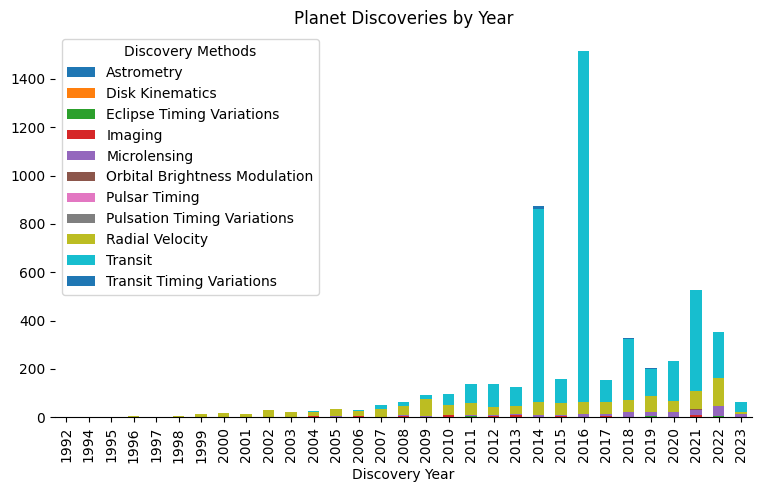

In [9]:
df.groupby(['disc_year','discoverymethod']).size().unstack().plot.bar(stacked=True,figsize=(9,5))
plt.xlabel('Discovery Year')
plt.legend(title='Discovery Methods')
plt.title('Planet Discoveries by Year')
sns.despine(left=True)
sns.set_theme(style="ticks")
plt.show()

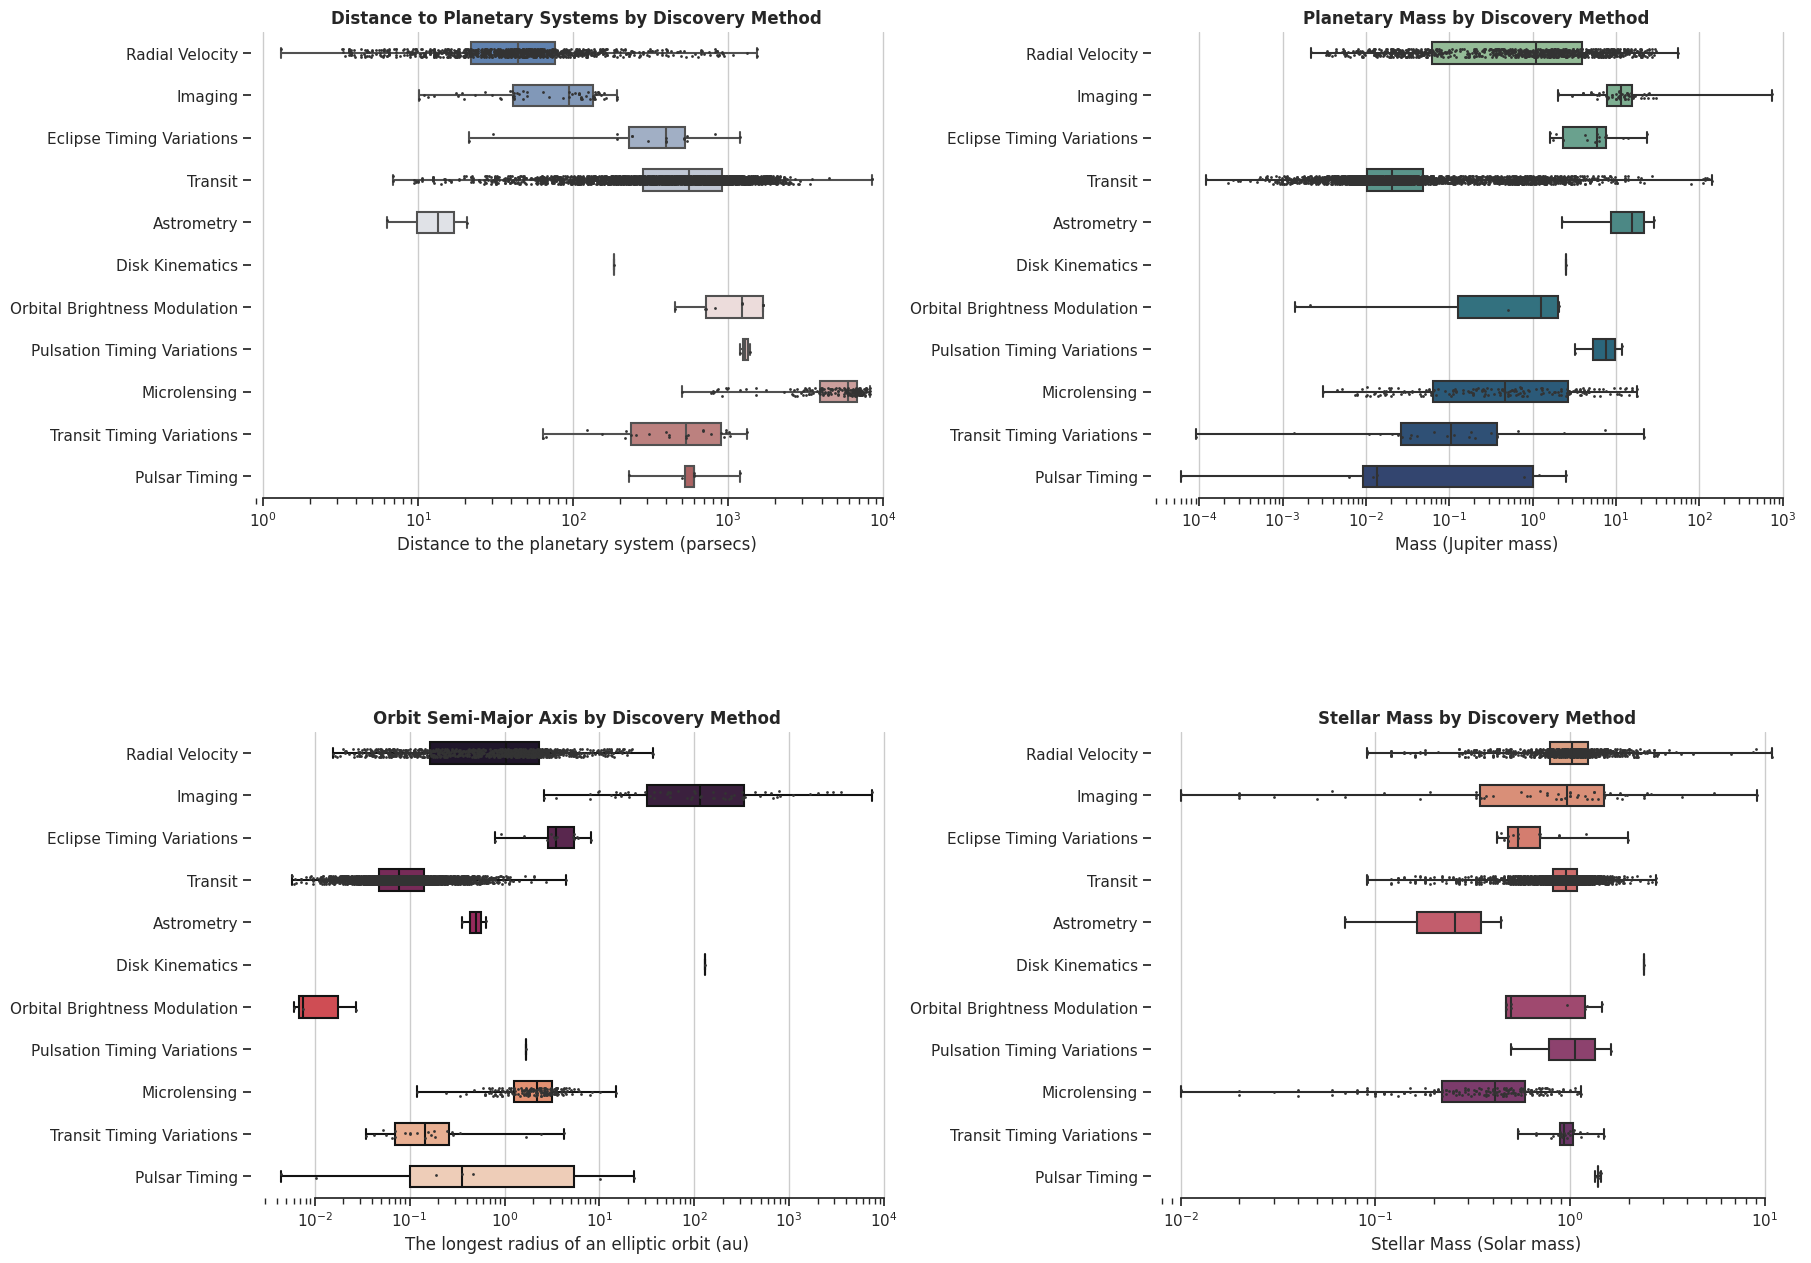

In [10]:
sns.set_theme(style='ticks')
fig, ax = plt.subplots(2, 2, figsize=(20, 16))
fig.tight_layout(pad=12)
ax1 = ax[0,0]
ax2 = ax[0,1]
ax3 = ax[1,0]
ax4 = ax[1,1]

sns.boxplot(x='sy_dist', y='discoverymethod', data=df, whis=[0, 100], width=0.5, palette='vlag', ax=ax1)
sns.stripplot(x='sy_dist', y='discoverymethod', data=df, size=2, color='0.2', linewidth=0, ax=ax1)
ax1.set_xscale('log')
ax1.xaxis.grid(True)
ax1.set_ylabel('')
ax1.set_xlabel('Distance to the planetary system (parsecs)')
ax1.set_title('Distance to Planetary Systems by Discovery Method', fontweight='bold')
sns.despine(trim=True, left=True, ax=ax1)


sns.boxplot(x='pl_bmassj', y='discoverymethod', data=df, whis=[0, 100], width=0.5, palette='crest',  ax=ax2)
sns.stripplot(x='pl_bmassj', y='discoverymethod', data=df, size=2, color='0.2', linewidth=0, ax=ax2)
ax2.set_xscale('log')
ax2.xaxis.grid(True)
ax2.set_ylabel('')
ax2.set_xlabel('Mass (Jupiter mass)')
ax2.set_title('Planetary Mass by Discovery Method', fontweight='bold')
sns.despine(trim=True, left=True, ax=ax2)


sns.boxplot(x='pl_orbsmax', y='discoverymethod', data=df, whis=[0, 100], width=0.5, palette='rocket', ax=ax3)
sns.stripplot(x='pl_orbsmax', y='discoverymethod', data=df, size=2, color='0.2', linewidth=0, ax=ax3)
ax3.set_xscale('log')
ax3.xaxis.grid(True)
ax3.set_ylabel('')
ax3.set_xlabel('The longest radius of an elliptic orbit (au)')
ax3.set_title('Orbit Semi-Major Axis by Discovery Method', fontweight='bold')
sns.despine(trim=True, left=True, ax=ax3)


sns.boxplot(x='st_mass', y='discoverymethod', data=df, whis=[0, 100], width=0.5, palette='flare', ax=ax4)
sns.stripplot(x='st_mass', y='discoverymethod', data=df, size=2, color='0.2', linewidth=0, ax=ax4)
ax4.set_xscale('log')
ax4.xaxis.grid(True)
ax4.set_ylabel('')
ax4.set_xlabel('Stellar Mass (Solar mass)')
ax4.set_title('Stellar Mass by Discovery Method', fontweight='bold')
sns.despine(trim=True, left=True, ax=ax4)

## Stellar host

Grouping the planets by their host star name returns 3989 distinct planetary system, some of which have as many as 8 planets in orbit.

In [11]:
stars = df.groupby('hostname').agg(num_planets=('hostname', 'count'))
print(f"Total number of distinct stars: {stars.shape[0]}")
planet_count = stars.groupby('num_planets').agg(count=('num_planets', 'count')).sort_values(by='num_planets')
planet_count

Total number of distinct stars: 3989


,count
num_planets,
1,3108
2,587
3,188
4,69
5,25
6,10
7,1
8,1


## Binary and multiple star systems

In some cases, a small number of stars orbit each other, bound by gravitational attraction. In the NASA exoplanet dataset, some exoplanets have been found in these binary or multiple star systems. Some exoplanets orbit around one of the double or multiple stars, while a smaller number of exoplanets orbit around two stars instead of one, which is known as a circumbinary planet.

In [12]:
# Planets in binary or multiple star system
df.loc[df['sy_snum'] > 1][['hostname','pl_name','sy_snum','sy_pnum','cb_flag']].sort_values(by=['sy_snum','sy_pnum','hostname','pl_name'], ascending=[False,False,True,True]).describe()

,sy_snum,sy_pnum
count,483.000000,483.000000
mean,2.120083,1.853002
std,0.337907,1.267666
min,2.000000,1.000000
25%,2.000000,1.000000
50%,2.000000,1.000000
75%,2.000000,2.000000
max,4.000000,6.000000


In [13]:
# Circumbinary planet
df.loc[(df['sy_snum'] > 1) & (df['cb_flag'] == 1)][['hostname','pl_name','sy_snum','sy_pnum','cb_flag']].sort_values(by=['hostname','pl_name']).describe()

,sy_snum,sy_pnum
count,45.000000,45.000000
mean,2.044444,1.488889
std,0.298142,0.726831
min,2.000000,1.000000
25%,2.000000,1.000000
50%,2.000000,1.000000
75%,2.000000,2.000000
max,4.000000,3.000000


## Exoplanet naming convention

Only a few exoplanets have 'proper names,' but all have designations. The first part of the designation usually indicates the telescope or survey that discovered it, followed by the number indicating the position of the star in the catalog. Lastly, the lowercase letter stands for the planet in the order it was discovered, with the first planet being named 'b' (as 'A' is reserved for the star). If multiple exoplanets are found around the same star, the closest planet to the star is named 'b', and the more distant planets are named 'c', 'd', 'e', and so on.

## Web scraping exoplanet types

Scientists have categorized the discoverd planets into the 4 following categories: Neptunian, Gas giant, Super-earth, Terrestrial.

Although the NASA Exoplanet Archive doesn't include the exoplanet type data for each planet, I was able to obtain this information from the [NASA's exoplanet catalog](https://exoplanets.nasa.gov/discovery/exoplanet-catalog/) site. To do this, I wrote a [web_scraper.py](/web_scraping/web_scraper.py) script that scraped the data and saved it to [nasa_exoplanet_catalog.csv](/web_scraping/nasa_exoplanet_catalog.csv). By merging the two datasets using the identifying columns, I can add the exoplanet type information to the original data. Turns out the column *ranger_feature_id* from the new dataset and *pl_name* from the original can be matched with a small modification.

The data was acquired on 2023-04-06.

#### Neptunian
- similar in size to Neptune or Uranus that typically have hydrogen and helium-dominated atmospheres with cores of rock and heavier metals.
- 1835 planets discovered
#### Gas giant
- a giant planet composed mainly of gas (helium and or hydrogen)
- 1679 planets discovered
- "hot Jupiters", gas giants nearer to their stars make such tight orbits that they cause a pronounced wobble in their stars, making it easier to detect using the radial velocity method.
#### Super-Earth
- more massive than Earth yet lighter than ice giants like Neptune and Uranus, and can be made of gas, rock or a combination of both
- 1608 planets discovered
#### Terrestrial
- Earth sized and smaller composed of rock, silicate, water or carbon
- 195 planets discovered
#### Unknown
- 5 planets discovered

In [14]:
df_ws = pd.read_csv('web_scraping/nasa_exoplanet_catalog.csv')
df_ws.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5322 entries, 0 to 5321
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5322 non-null   int64  
 1   pl_hostname        5322 non-null   object 
 2   pl_letter          5322 non-null   object 
 3   display_name       5322 non-null   object 
 4   description        5322 non-null   object 
 5   discovery_date     5322 non-null   int64  
 6   url                5322 non-null   object 
 7   title              5322 non-null   object 
 8   feature_title      5322 non-null   object 
 9   mass_display       5322 non-null   object 
 10  planet_type        5322 non-null   object 
 11  st_dist            5304 non-null   float64
 12  st_optmag          5134 non-null   float64
 13  pl_radj            5304 non-null   float64
 14  pl_rade            5305 non-null   float64
 15  pl_massj           5298 non-null   float64
 16  pl_discmethod      5322 

In [15]:
df['pl_name_lower'] = df['pl_name'].str.lower().str.replace(' ', '_') # Make the name lower case and replace space character with underscores
df_ws['ranger_feature_id'] = df_ws['ranger_feature_id'].str.lower() 
merged = pd.merge(df, df_ws[['ranger_feature_id', 'planet_type']], how='left', left_on = 'pl_name_lower', right_on = 'ranger_feature_id')
df = merged.drop(['pl_name_lower', 'ranger_feature_id'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5322 entries, 0 to 5321
Data columns (total 72 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   pl_name          5322 non-null   object 
 1   hostname         5322 non-null   object 
 2   sy_snum          5322 non-null   int64  
 3   sy_pnum          5322 non-null   int64  
 4   sy_mnum          5322 non-null   int64  
 5   cb_flag          5322 non-null   bool   
 6   discoverymethod  5322 non-null   object 
 7   disc_year        5322 non-null   int64  
 8   disc_locale      5322 non-null   object 
 9   disc_facility    5322 non-null   object 
 10  disc_telescope   5322 non-null   object 
 11  disc_instrument  5322 non-null   object 
 12  rv_flag          5322 non-null   bool   
 13  pul_flag         5322 non-null   bool   
 14  ptv_flag         5322 non-null   bool   
 15  tran_flag        5322 non-null   bool   
 16  ast_flag         5322 non-null   bool   
 17  obm_flag      

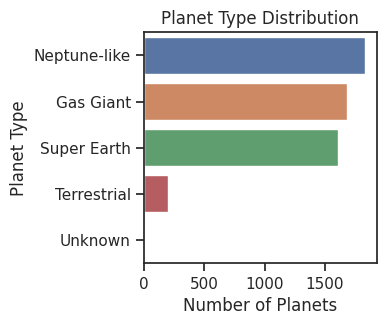

In [16]:
fig, ax = plt.subplots(figsize=(3, 3))
planet_types = df['planet_type'].value_counts()
sns.barplot(x=planet_types.values, y=planet_types.index)
plt.title('Planet Type Distribution')
plt.xlabel('Number of Planets')
plt.ylabel('Planet Type')
plt.show()

## Exoplanet physical characteristics

In some cases, scientists may not have the exact mass of a planet but they may have other data that can be used to calculate the *minimum mass* of the planet. If they can also determine the orbital inclination *i*, the true mass can be obtained from the calculated minimum mass using the following relationship:

$$ M_{true} = {M_{min} \over sin(i)} $$

The column *pl_bmassj* provides the best planet mass estimate available, in order of preference: $M_{true}$, $M_{min} \cdot sin(i) \over sin(i)$, or $M_{min} \cdot sin(i)$, depending on availability. The column *pl_bmassprov* specifies the provenance of the measurement. If no mass estimates are available for a given planet, it will be excluded from the analysis. Additionally, we will remove outliers that fall outside of the interquartile range.

Same method can be applied to the column *pl_radj*, *pl_dens* and *pl_eq*.

In [17]:
print(f"df['pl_bmassj']  min: {df['pl_bmassj'].min():<10} max: {df['pl_bmassj'].max():<10} mean: {df['pl_bmassj'].mean():<10}")
print(f"df['pl_radj']    min: {df['pl_radj'].min():<10} max: {df['pl_radj'].max():<10} mean: {df['pl_radj'].mean():<10}")
print(f"df['pl_dens']    min: {df['pl_dens'].min():<10} max: {df['pl_dens'].max():<10} mean: {df['pl_dens'].mean():<10}")
print(f"df['pl_eqt']     min: {df['pl_eqt'].min():<10} max: {df['pl_eqt'].max():<10} mean: {df['pl_eqt'].mean():<10}")

df['pl_bmassj']  min: 6e-05      max: 752.0      mean: 1.4472003095507737
df['pl_radj']    min: 0.026      max: 6.9        mean: 0.5071809954751131
df['pl_dens']    min: 0.03       max: 1290.0     mean: 4.257565028242075
df['pl_eqt']     min: 34.0       max: 4050.0     mean: 916.2669383596536


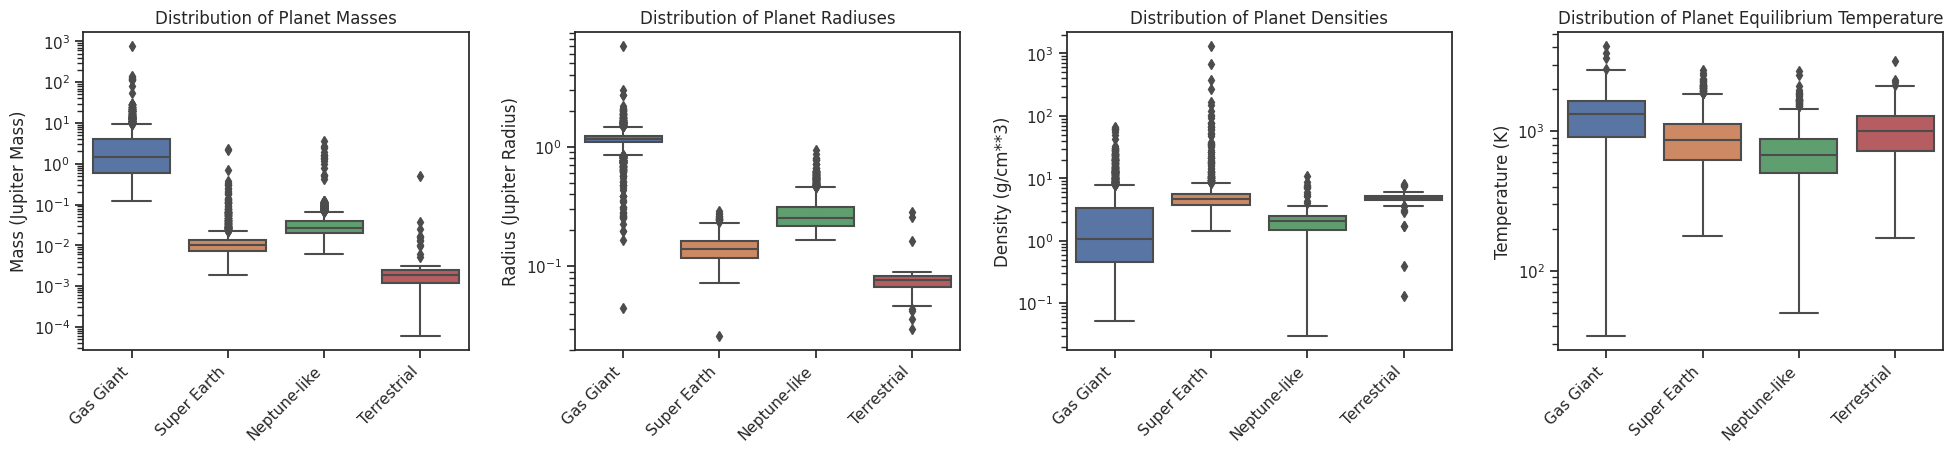

In [18]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

masses = df.loc[df['pl_bmassj'].notnull()][['pl_bmassj','planet_type']]
radiuses = df.loc[df['pl_radj'].notnull()][['pl_radj','planet_type']]
densities = df.loc[df['pl_dens'].notnull()][['pl_dens','planet_type']]
temperatures = df.loc[df['pl_eqt'].notnull()][['pl_eqt','planet_type']]


sns.boxplot(y='pl_bmassj', x='planet_type', data=masses, ax=ax[0], showfliers=True)
ax[0].set_title('Distribution of Planet Masses')
ax[0].set_ylabel('Mass (Jupiter Mass)')
ax[0].set_xlabel('')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha='right')
ax[0].set_yscale('log')

sns.boxplot(y='pl_radj', x='planet_type', data=radiuses, ax=ax[1], showfliers=True)
ax[1].set_title('Distribution of Planet Radiuses')
ax[1].set_ylabel('Radius (Jupiter Radius)')
ax[1].set_xlabel('')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha='right')
ax[1].set_yscale('log')

sns.boxplot(y='pl_dens', x='planet_type', data=densities, ax=ax[2], showfliers=True)
ax[2].set_title('Distribution of Planet Densities')
ax[2].set_ylabel('Density (g/cm**3)')
ax[2].set_xlabel('')
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=45, ha='right')
ax[2].set_yscale('log')

sns.boxplot(y='pl_eqt', x='planet_type', data=temperatures, ax=ax[3], showfliers=True)
ax[3].set_title('Distribution of Planet Equilibrium Temperature')
ax[3].set_ylabel('Temperature (K)')
ax[3].set_xlabel('')
ax[3].set_xticklabels(ax[3].get_xticklabels(), rotation=45, ha='right')
ax[3].set_yscale('log')

fig.tight_layout(pad=2)
plt.show()

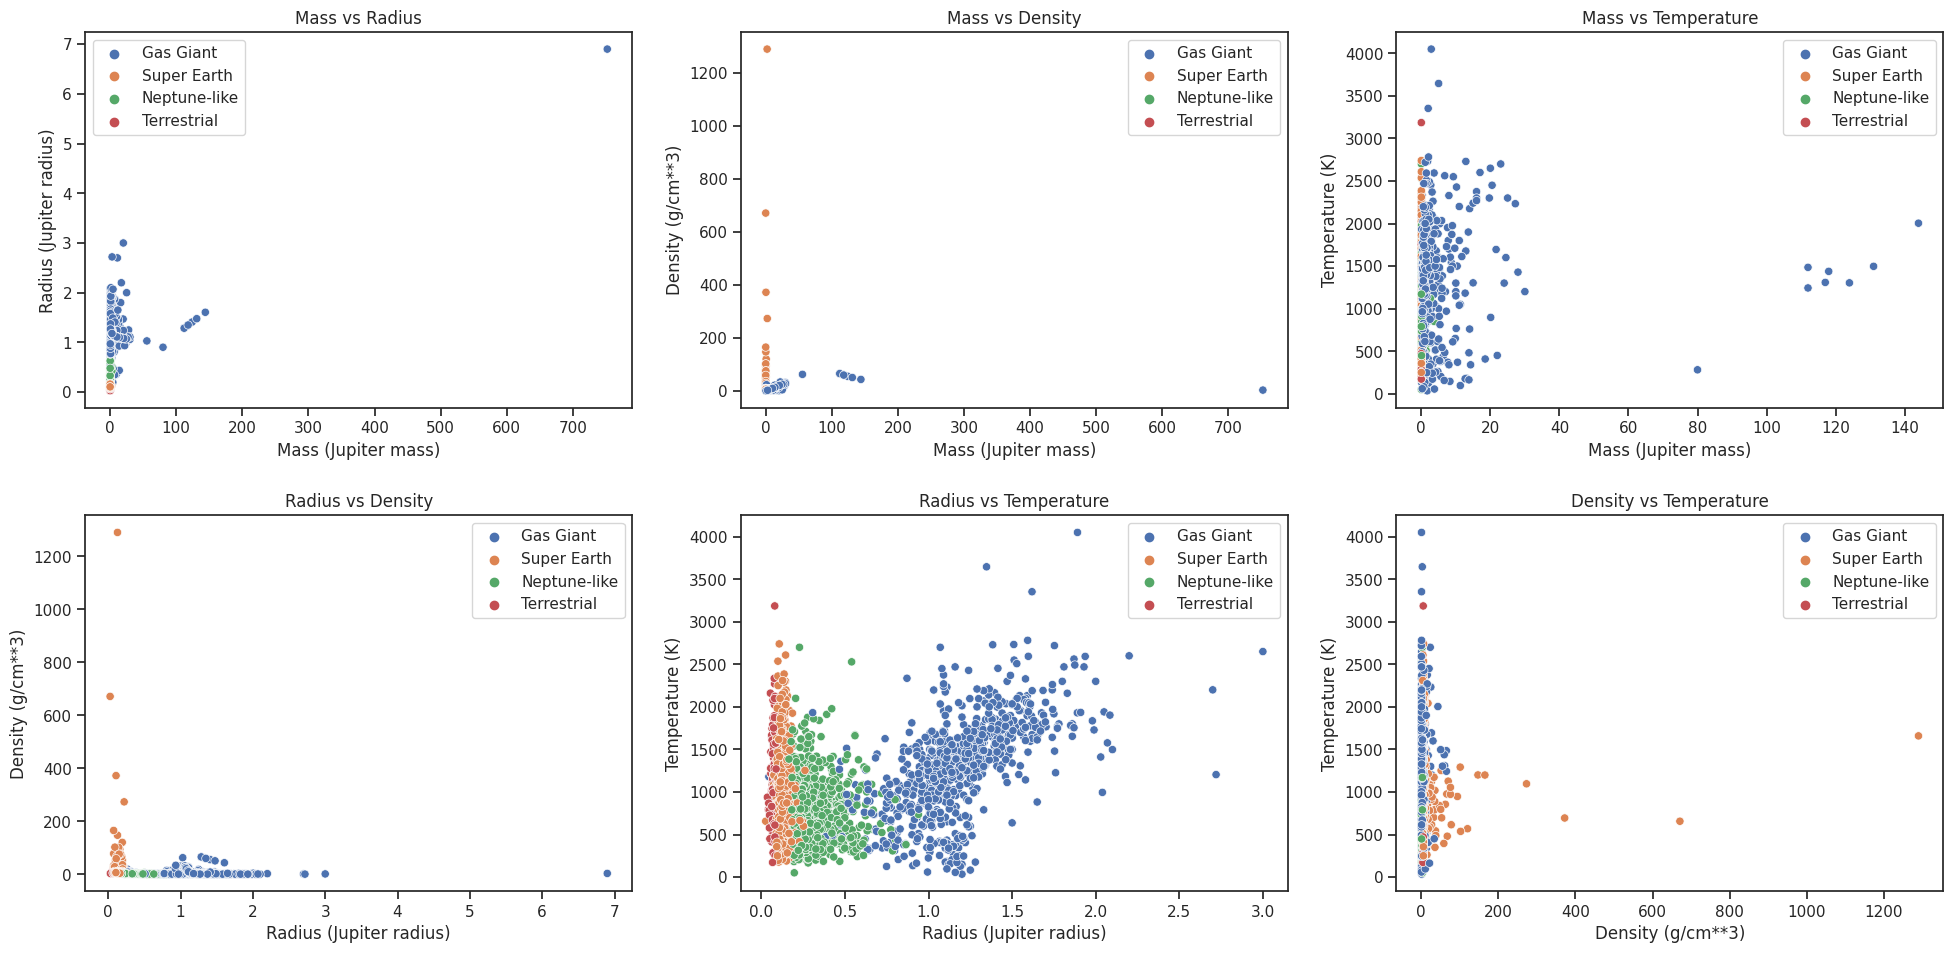

In [19]:
fig, ax = plt.subplots(2,3, figsize=(20, 10))


mr = df.loc[(df['pl_bmassj'].notnull()) & (df['pl_radj'].notnull())][['pl_bmassj', 'pl_radj', 'planet_type']]
md = df.loc[(df['pl_bmassj'].notnull()) & (df['pl_dens'].notnull())][['pl_bmassj', 'pl_dens', 'planet_type']]
mt = df.loc[(df['pl_bmassj'].notnull()) & (df['pl_eqt'].notnull())][['pl_bmassj', 'pl_eqt', 'planet_type']]
rd = df.loc[(df['pl_radj'].notnull()) & (df['pl_dens'].notnull())][['pl_radj', 'pl_dens', 'planet_type']]
rt = df.loc[(df['pl_radj'].notnull()) & (df['pl_eqt'].notnull())][['pl_radj', 'pl_eqt', 'planet_type']]
dt = df.loc[(df['pl_dens'].notnull()) & (df['pl_eqt'].notnull())][['pl_dens', 'pl_eqt', 'planet_type']]


sns.scatterplot(x='pl_bmassj', y='pl_radj', data=mr, ax=ax[0,0], hue='planet_type')
ax[0, 0].legend().set_title('')
ax[0, 0].set_title('Mass vs Radius')
ax[0, 0].set_ylabel('Radius (Jupiter radius)')
ax[0, 0].set_xlabel('Mass (Jupiter mass)')

sns.scatterplot(x='pl_bmassj', y='pl_dens', data=md, ax=ax[0,1], hue='planet_type')
ax[0, 1].legend().set_title('')
ax[0, 1].set_title('Mass vs Density')
ax[0, 1].set_ylabel('Density (g/cm**3)')
ax[0, 1].set_xlabel('Mass (Jupiter mass)')


sns.scatterplot(x='pl_bmassj', y='pl_eqt', data=mt, ax=ax[0, 2], hue='planet_type')
ax[0, 2].legend().set_title('')
ax[0, 2].set_title('Mass vs Temperature')
ax[0, 2].set_ylabel('Temperature (K)')
ax[0, 2].set_xlabel('Mass (Jupiter mass)')


sns.scatterplot(x='pl_radj', y='pl_dens', data=rd, ax=ax[1, 0], hue='planet_type')
ax[1, 0].legend().set_title('')
ax[1, 0].set_title('Radius vs Density')
ax[1, 0].set_ylabel('Density (g/cm**3)')
ax[1, 0].set_xlabel('Radius (Jupiter radius)')


sns.scatterplot(x='pl_radj', y='pl_eqt', data=rt, ax=ax[1,1], hue='planet_type')
ax[1, 1].legend().set_title('')
ax[1, 1].set_title('Radius vs Temperature')
ax[1, 1].set_ylabel('Temperature (K)')
ax[1, 1].set_xlabel('Radius (Jupiter radius)')

sns.scatterplot(x='pl_dens', y='pl_eqt', data=dt, ax=ax[1,2], hue='planet_type')
ax[1, 2].legend().set_title('')
ax[1, 2].set_title('Density vs Temperature')
ax[1, 2].set_ylabel('Temperature (K)')
ax[1, 2].set_xlabel('Density (g/cm**3)')

fig.tight_layout(pad=2)
plt.show()

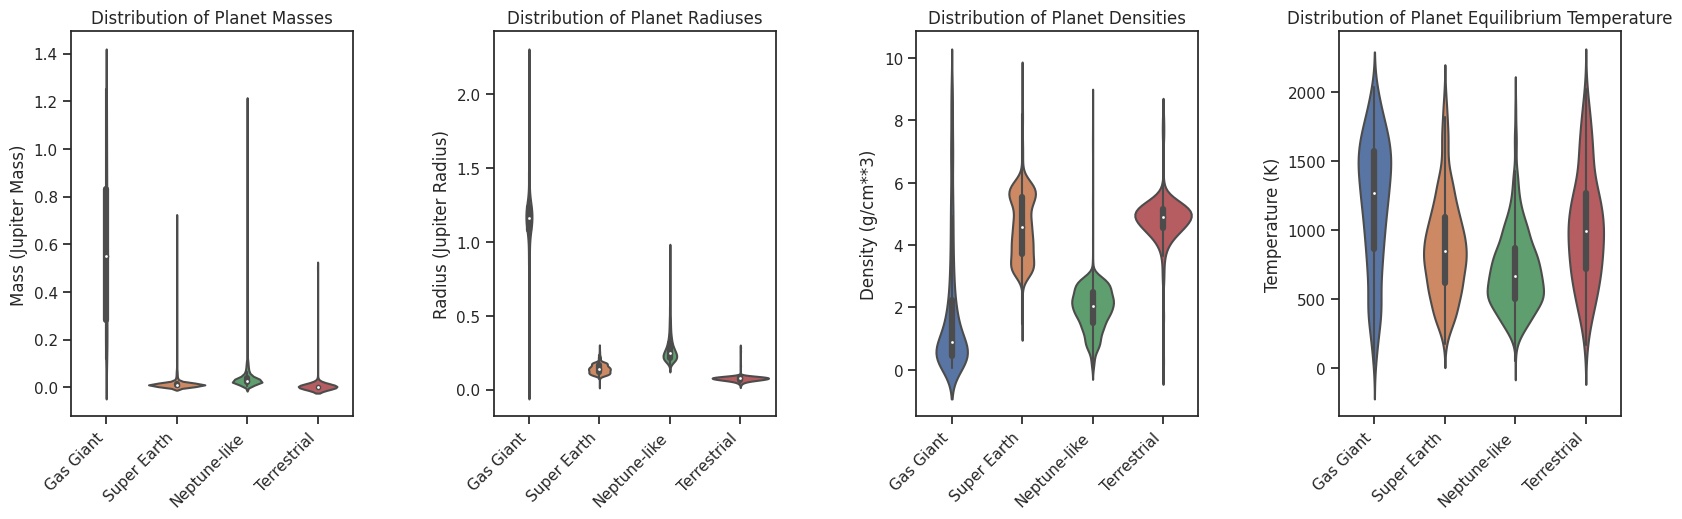

In [20]:
# Removing outliers


# Mass
q1 = df['pl_bmassj'].describe()['25%']
q3 = df['pl_bmassj'].describe()['75%']
IQR = q3 - q1
upper_lim = q3+1.5*IQR
lower_lim = q1-1.5*IQR
masses = df.loc[(df['pl_bmassj'].notnull() & df['pl_bmassj'] > lower_lim) & (df['pl_bmassj'] < upper_lim)][['pl_bmassj', 'planet_type', 'pl_name']]

# Radius
q1 = df['pl_radj'].describe()['25%']
q3 = df['pl_radj'].describe()['75%']
IQR = q3 - q1
upper_lim = q3+1.5*IQR
lower_lim = q1-1.5*IQR
radiuses = df.loc[(df['pl_radj'].notnull() & df['pl_radj'] > lower_lim) & (df['pl_radj'] < upper_lim)][['pl_radj', 'planet_type', 'pl_name']]


# Density
q1 = df['pl_dens'].describe()['25%']
q3 = df['pl_dens'].describe()['75%']
IQR = q3 - q1
upper_lim = q3+1.5*IQR
lower_lim = q1-1.5*IQR
densities = df.loc[(df['pl_dens'].notnull() & df['pl_dens'] > lower_lim) & (df['pl_dens'] < upper_lim)][['pl_dens', 'planet_type', 'pl_name']]


# Temperature
q1 = df['pl_eqt'].describe()['25%']
q3 = df['pl_eqt'].describe()['75%']
IQR = q3 - q1
upper_lim = q3+1.5*IQR
lower_lim = q1-1.5*IQR
temperatures = df.loc[(df['pl_eqt'].notnull() & df['pl_eqt'] > lower_lim) & (df['pl_eqt'] < upper_lim)][['pl_eqt', 'planet_type', 'pl_name']]

fig, ax = plt.subplots(1, 4, figsize=(20, 5))
sns.violinplot(y='pl_bmassj', x='planet_type', data=masses, ax=ax[0])
ax[0].set_title('Distribution of Planet Masses')
ax[0].set_ylabel('Mass (Jupiter Mass)')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha='right')
ax[0].set_xlabel('')


sns.violinplot(y='pl_radj', x='planet_type', data=radiuses, ax=ax[1])
ax[1].set_title('Distribution of Planet Radiuses')
ax[1].set_ylabel('Radius (Jupiter Radius)')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha='right')
ax[1].set_xlabel('')


sns.violinplot(y='pl_dens', x='planet_type', data=densities, ax=ax[2])
ax[2].set_title('Distribution of Planet Densities')
ax[2].set_ylabel('Density (g/cm**3)')
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=45, ha='right')
ax[2].set_xlabel('')


sns.violinplot(y='pl_eqt', x='planet_type', data=temperatures, ax=ax[3])
ax[3].set_title('Distribution of Planet Equilibrium Temperature')
ax[3].set_ylabel('Temperature (K)')
ax[3].set_xticklabels(ax[3].get_xticklabels(), rotation=45, ha='right')
ax[3].set_xlabel('')


fig.subplots_adjust(wspace=0.5)
plt.show()

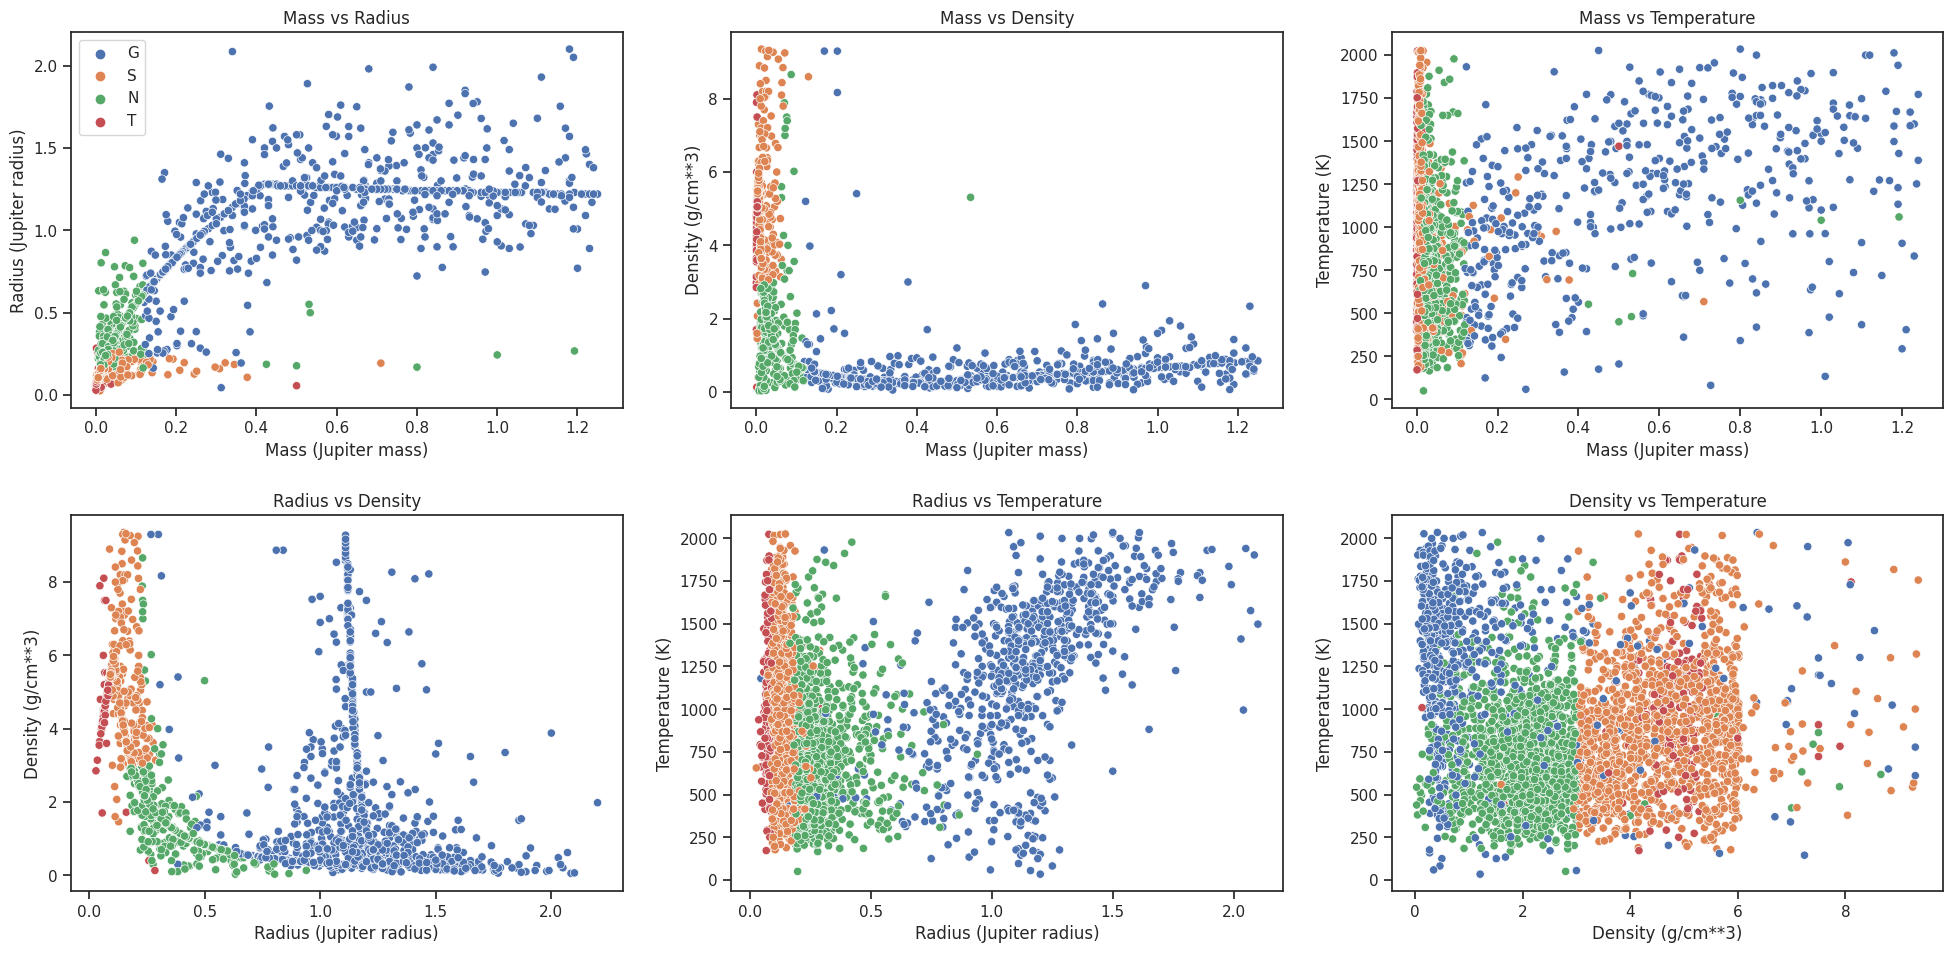

In [21]:
fig, ax = plt.subplots(2,3, figsize=(20, 10))

mr = pd.merge(masses, radiuses, how='inner', on=['pl_name', 'planet_type'])
md = pd.merge(masses, densities, how='inner', on=['pl_name', 'planet_type'])
mt = pd.merge(masses, temperatures, how='inner', on=['pl_name', 'planet_type'])
rd = pd.merge(radiuses, densities, how='inner', on=['pl_name', 'planet_type'])
rt = pd.merge(radiuses, temperatures, how='inner', on=['pl_name', 'planet_type'])
dt = pd.merge(densities, temperatures, how='inner', on=['pl_name', 'planet_type'])

sns.scatterplot(x='pl_bmassj', y='pl_radj', data=mr, ax=ax[0,0], hue='planet_type')
ax[0, 0].set_title('Mass vs Radius')
ax[0, 0].set_ylabel('Radius (Jupiter radius)')
ax[0, 0].set_xlabel('Mass (Jupiter mass)')
handles, labels = ax[0, 0].get_legend_handles_labels()
ax[0, 0].legend(handles=handles, labels=[s[0].upper() for s in labels])

sns.scatterplot(x='pl_bmassj', y='pl_dens', data=md, ax=ax[0,1], hue='planet_type')
ax[0, 1].set_title('Mass vs Density')
ax[0, 1].set_ylabel('Density (g/cm**3)')
ax[0, 1].set_xlabel('Mass (Jupiter mass)')
ax[0, 1].legend().remove()


sns.scatterplot(x='pl_bmassj', y='pl_eqt', data=mt, ax=ax[0, 2], hue='planet_type')
ax[0, 2].set_title('Mass vs Temperature')
ax[0, 2].set_ylabel('Temperature (K)')
ax[0, 2].set_xlabel('Mass (Jupiter mass)')
ax[0, 2].legend().remove()


sns.scatterplot(x='pl_radj', y='pl_dens', data=rd, ax=ax[1, 0], hue='planet_type')
ax[1, 0].set_title('Radius vs Density')
ax[1, 0].set_ylabel('Density (g/cm**3)')
ax[1, 0].set_xlabel('Radius (Jupiter radius)')
ax[1, 0].legend().remove()

sns.scatterplot(x='pl_radj', y='pl_eqt', data=rt, ax=ax[1,1], hue='planet_type')
ax[1, 1].set_title('Radius vs Temperature')
ax[1, 1].set_ylabel('Temperature (K)')
ax[1, 1].set_xlabel('Radius (Jupiter radius)')
ax[1, 1].legend().remove()

sns.scatterplot(x='pl_dens', y='pl_eqt', data=dt, ax=ax[1,2], hue='planet_type')
ax[1, 2].set_title('Density vs Temperature')
ax[1, 2].set_ylabel('Temperature (K)')
ax[1, 2].set_xlabel('Density (g/cm**3)')
ax[1, 2].legend().remove()

fig.tight_layout(pad=2)
plt.show()

In [22]:
print(f"Number of planets with unknown value of mass: {df['pl_bmassj'].isnull().sum()} \n"
      f"Number of planets with unknown value of radius: {df['pl_radj'].isnull().sum()} \n"
      f"Number of planets with unknown value of density: {df['pl_dens'].isnull().sum()} \n"
      f"Number of planets with unknown value of temperature: {df['pl_eqt'].isnull().sum()}")

Number of planets with unknown value of mass: 24 
Number of planets with unknown value of radius: 18 
Number of planets with unknown value of density: 117 
Number of planets with unknown value of temperature: 1396


In [23]:
# TODO Normalize distribution

## Orbital Parameters

<div align="center">
    <img alt="semimajor axis" src="./img/semi-major-axis.png" width="250">
    <img alt="orbital plane" src="./img/orbital-plane.png" width="350">
</div>


#### Size and shape of the orbit
+ Semi-major axis
    - determines the size of the ellipse 
    - ${d_{periapsis} + d_{apoapsis}} \over 2$ or simply, half length of the major axis in the ellipse
    - *pl_orbsmax*
+ Eccentricity
    - determines the shape of the ellipse
    - how elongated compared to circle
    - *pl_orbeccen*
#### Orientation of the orbit
+ Inclination
    - vertical tilt of the ellipse with respect to the reference plane, measured at the ascending node (where the orbit passes upward through the reference plane, the green angle i in the diagram)
    - *pl_orbincl*
+ Argument of periasitron
    - defines the orientation of the ellipse in the orbital plane, as an angle measured from the ascending node to the periapsis (the closest point the satellite object comes to the primary object around which it orbits, the blue angle ω in the diagram)
    - *pl_orblper* <a href="#footnote-1">[1]</a>

#### Other
+ Orbital period
    - time the planet takes to maek a complete orbit around the host star or system
    - *pl_orbper*
+ Impact parameter
    - The sky-projected distance between the center of the stellar disc and the center of the planet disc at conjunction, normalized by the stellar radius
    - *pl_imppar*
+ Transit depth
    - The size of the relative flux decrement caused by the orbiting body transiting in front of the star [%]
    - *pl_trandep*
+ Transit duration 
    - The length of time from the moment the planet begins to cross the stellar limb to the moment the planet finishes crossing the stellar limb [hrs]
    - *pl_trandur*
+ Ratio of semi-major axis to stellar radius
    - The distance between the planet and the star at mid-transit divided by the stellar radius. For the case of zero orbital eccentricity, the distance at mid-transit is the semi-major axis of the planetary orbit
    - *pl_ratdor*
+ Ratio of planet to stellar radius
    - The planet radius divided by the stellar radius
    - *pl_ratror*

<p id="footnote-1">[1] Values in the dataset is not corrected to a standardized system, some publications refer the planet's orbit, others to the host star's reflex orbit, which differs by 180 deg.</p>
    

#### Unknown parameters
Most exoplanets have been discovered using indirect methods and therefore only some of their orbital parameters can be determined. For example, radial-velocity method cannot determine the inclination nor the longitude of the ascending node.

In [24]:
print(f"Number of planets with unknown value of semi-major axis: {df['pl_orbsmax'].isnull().sum()} \n"
      f"Number of planets with unknown value of eccentricity: {df['pl_orbeccen'].isnull().sum()} \n"
      f"Number of planets with unknown value of inclination: {df['pl_orbincl'].isnull().sum()} \n"
      f"Number of planets with unknown value of orbital period: {df['pl_orbper'].isnull().sum()}")
# pl_orblper has been dropped from feature list

Number of planets with unknown value of semi-major axis: 288 
Number of planets with unknown value of eccentricity: 717 
Number of planets with unknown value of inclination: 1286 
Number of planets with unknown value of orbital period: 221


In [25]:
# TODO oribital radii and period scatter plot, color being the method of detection

In [26]:
# TODO habitable zone orbit